In [43]:
# Thêm autoreload vào để tự động reload lại module nếu có thay đổi code trong module
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Các model scikit learn cho bài toán phân loại
from sklearn.svm import SVC # Support vector machine
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import os, sys
sys.path.append(os.path.abspath(".."))
from utils.common import load_model, save_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Các thông tin về dữ liệu

In [44]:
train_df = pd.read_csv("train_clean.csv")

In [45]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2462 entries, 0 to 2461
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   label               2462 non-null   object 
 1   nose_x              2462 non-null   float64
 2   nose_y              2462 non-null   float64
 3   nose_z              2462 non-null   float64
 4   left_shoulder_x     2462 non-null   float64
 5   left_shoulder_y     2462 non-null   float64
 6   left_shoulder_z     2462 non-null   float64
 7   right_shoulder_x    2462 non-null   float64
 8   right_shoulder_y    2462 non-null   float64
 9   right_shoulder_z    2462 non-null   float64
 10  left_hip_x          2462 non-null   float64
 11  left_hip_y          2462 non-null   float64
 12  left_hip_z          2462 non-null   float64
 13  right_hip_x         2462 non-null   float64
 14  right_hip_y         2462 non-null   float64
 15  right_hip_z         2462 non-null   float64
 16  left_k

In [46]:
train_df.columns

Index(['label', 'nose_x', 'nose_y', 'nose_z', 'left_shoulder_x',
       'left_shoulder_y', 'left_shoulder_z', 'right_shoulder_x',
       'right_shoulder_y', 'right_shoulder_z', 'left_hip_x', 'left_hip_y',
       'left_hip_z', 'right_hip_x', 'right_hip_y', 'right_hip_z',
       'left_knee_x', 'left_knee_y', 'left_knee_z', 'right_knee_x',
       'right_knee_y', 'right_knee_z', 'left_ankle_x', 'left_ankle_y',
       'left_ankle_z', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z',
       'left_heel_x', 'left_heel_y', 'left_heel_z', 'right_heel_x',
       'right_heel_y', 'right_heel_z', 'left_foot_index_x',
       'left_foot_index_y', 'left_foot_index_z', 'right_foot_index_x',
       'right_foot_index_y', 'right_foot_index_z'],
      dtype='object')

In [47]:
train_df.head()

,label,nose_x,nose_y,nose_z,left_shoulder_x,left_shoulder_y,left_shoulder_z,right_shoulder_x,right_shoulder_y,right_shoulder_z,...,left_heel_z,right_heel_x,right_heel_y,right_heel_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z
0,D,-0.045332,-0.312278,0.025817,-0.003468,-0.236481,-0.137639,-0.004457,-0.237314,0.206035,...,0.029322,0.153061,0.134413,0.058777,-0.116457,0.233184,0.018748,0.134836,0.208726,0.050868
1,D,-0.036876,-0.316079,0.025362,0.002906,-0.249338,-0.161753,0.003340,-0.246322,0.212587,...,-0.180082,-0.070181,0.250603,0.154884,0.111356,0.274413,-0.231801,-0.121906,0.248574,0.139393
2,D,-0.042562,-0.311502,-0.002624,-0.000249,-0.237705,-0.156688,0.003185,-0.235856,0.168590,...,-0.050998,0.025495,0.195137,0.079456,0.044727,0.245372,-0.071741,0.005740,0.234293,0.069344
3,D,-0.043028,-0.309828,-0.012327,-0.003478,-0.232540,-0.164551,-0.006258,-0.231792,0.172023,...,-0.007732,0.168087,0.131500,0.049326,-0.100497,0.227354,-0.007181,0.144870,0.205615,0.041901
4,D,-0.035741,-0.315002,0.014858,0.005436,-0.248575,-0.154430,0.002749,-0.244614,0.200926,...,-0.049212,0.066569,0.230884,0.072321,-0.079495,0.282712,-0.086518,0.044977,0.273339,0.059026


### 2. Training model

In [48]:
# Chuyển dữ liệu của label về dạng số
from sklearn.preprocessing import LabelEncoder

# Khởi tạo LabelEncoder
label_encoder = LabelEncoder()

"""
0 -> D(down)
1 -> M(middle)
2 -> S(stand)
"""
train_df["label"] = label_encoder.fit_transform(train_df["label"])

In [49]:
# Extract features
X = train_df.drop(columns="label")
y = train_df["label"]

In [50]:
X.head()

,nose_x,nose_y,nose_z,left_shoulder_x,left_shoulder_y,left_shoulder_z,right_shoulder_x,right_shoulder_y,right_shoulder_z,left_hip_x,...,left_heel_z,right_heel_x,right_heel_y,right_heel_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z
0,-0.045332,-0.312278,0.025817,-0.003468,-0.236481,-0.137639,-0.004457,-0.237314,0.206035,-0.002482,...,0.029322,0.153061,0.134413,0.058777,-0.116457,0.233184,0.018748,0.134836,0.208726,0.050868
1,-0.036876,-0.316079,0.025362,0.002906,-0.249338,-0.161753,0.003340,-0.246322,0.212587,0.000023,...,-0.180082,-0.070181,0.250603,0.154884,0.111356,0.274413,-0.231801,-0.121906,0.248574,0.139393
2,-0.042562,-0.311502,-0.002624,-0.000249,-0.237705,-0.156688,0.003185,-0.235856,0.168590,-0.002056,...,-0.050998,0.025495,0.195137,0.079456,0.044727,0.245372,-0.071741,0.005740,0.234293,0.069344
3,-0.043028,-0.309828,-0.012327,-0.003478,-0.232540,-0.164551,-0.006258,-0.231792,0.172023,-0.002649,...,-0.007732,0.168087,0.131500,0.049326,-0.100497,0.227354,-0.007181,0.144870,0.205615,0.041901
4,-0.035741,-0.315002,0.014858,0.005436,-0.248575,-0.154430,0.002749,-0.244614,0.200926,-0.000541,...,-0.049212,0.066569,0.230884,0.072321,-0.079495,0.282712,-0.086518,0.044977,0.273339,0.059026


In [51]:
y

0       0
1       0
2       0
3       0
4       0
       ..
2457    2
2458    2
2459    2
2460    2
2461    2
Name: label, Length: 2462, dtype: int32

In [52]:
# Phân chia dữ liệu thành tập huấn luyện và tập validation
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.15, random_state=42)

In [53]:
X_train.shape, X_validation.shape

((2092, 39), (370, 39))

In [54]:
# Chuẩn hoá dữ liệu trên tập huấn luyện bằng z-scores
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)

In [55]:
# X lúc này là một DataFrame mới với các cột mới được đánh số từ 0 đến n-1, trong đó n là số lượng cột trong dữ liệu ban đầu
X_train

array([[ 1.26175805,  1.18590092,  0.56620924, ...,  1.42419052,
        -0.86382614, -0.50572798],
       [ 0.97249864, -0.72701519,  0.4022507 , ...,  0.29617165,
         1.2008405 , -0.82471145],
       [ 0.07920134,  1.14894683, -3.75172342, ..., -0.55527747,
        -0.05264045, -2.4806678 ],
       ...,
       [-0.59688   ,  0.63608512,  0.39935173, ...,  0.81614048,
        -0.58653115, -0.06932136],
       [ 1.50885583,  1.42583692,  0.68483774, ...,  1.58269935,
        -0.6045464 , -0.59165748],
       [ 1.45351662, -0.34519326,  0.50338079, ..., -1.33481636,
        -0.37091711, -0.75480571]])

In [56]:
from sklearn.metrics import (
    precision_score,
    accuracy_score,
    f1_score,
    recall_score,
    confusion_matrix,
)

import warnings

warnings.filterwarnings("ignore")

In [57]:
def round_up_metric_results(results) -> list:
    """Thực hiện việc làm tròn các giá trị trong mảng"""
    return list(map(lambda el: round(el, 3), results))

In [58]:
def evaluate_model(name, model, final_results):
    # Đánh giá Model
    y_validation_pred = model.predict(X_validation)

    # Do các số lượng mẫu theo từng nhãn không cân bằng nhau nên sẽ sử dụng weight-average để đánh giá
    p_score = precision_score(y_validation, y_validation_pred, average="weighted")
    a_score = accuracy_score(y_validation, y_validation_pred)
    r_score = recall_score(y_validation, y_validation_pred, average="weighted")
    f1_score_result = f1_score(y_validation, y_validation_pred, average=None, labels=[0, 1, 2])
    cm = confusion_matrix(y_validation, y_validation_pred, labels=[0, 1, 2])
    
    final_results.append(
        (
            name,
            p_score,
            a_score,
            r_score,
            round_up_metric_results(f1_score_result),
            cm,
        )
    )

In [59]:
random_state_value = 42
algorithms = [
    ("LR", LogisticRegression(random_state=random_state_value)),
    ("SVC", SVC(probability=True, random_state=random_state_value)),
    ("KNN", KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier(random_state=random_state_value)),
    ("NB", GaussianNB()),
    ("RF", RandomForestClassifier(random_state=random_state_value)),
    ("Ridge", RidgeClassifier()),
    ("SGDC", SGDClassifier())
]

models = {}
final_results = []

for name, model in algorithms:
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model

    evaluate_model(name, model, final_results)

In [60]:
def print_results(final_results):
    # Sort results by F1 score
    final_results.sort(key=lambda k: sum(k[4]), reverse=True)

    return pd.DataFrame(
        final_results,
        columns=[
            "Model",
            "Precision Score",
            "Accuracy score",
            "Recall Score",
            "F1 score",
            "Confusion Matrix",
        ],
    )

print_results(final_results)

,Model,Precision Score,Accuracy score,Recall Score,F1 score,Confusion Matrix
0,RF,0.921834,0.921622,0.921622,"[0.917, 0.912, 0.947]","[[111, 8, 0], [12, 150, 5], [0, 4, 80]]"
1,SVC,0.922250,0.921622,0.921622,"[0.922, 0.911, 0.942]","[[112, 7, 0], [12, 148, 7], [0, 3, 81]]"
2,KNN,0.908503,0.908108,0.908108,"[0.914, 0.896, 0.924]","[[111, 8, 0], [13, 146, 8], [0, 5, 79]]"
3,LR,0.890064,0.889189,0.889189,"[0.894, 0.873, 0.912]","[[110, 9, 0], [17, 141, 9], [0, 6, 78]]"
4,DTC,0.887401,0.886486,0.886486,"[0.887, 0.876, 0.908]","[[106, 13, 0], [14, 148, 5], [0, 10, 74]]"
5,SGDC,0.868725,0.867568,0.867568,"[0.879, 0.851, 0.883]","[[109, 10, 0], [20, 140, 7], [0, 12, 72]]"
6,Ridge,0.824500,0.816216,0.816216,"[0.836, 0.781, 0.852]","[[112, 7, 0], [37, 121, 9], [0, 15, 69]]"
7,NB,0.797248,0.764865,0.764865,"[0.774, 0.703, 0.847]","[[111, 8, 0], [52, 97, 18], [5, 4, 75]]"


### 3 Model tốt nhất hiện tại: RF, DTC, SVC

In [61]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#### a. Điều chỉnh siêu tham số cho Random Forest

In [ ]:
random_forest = models["RF"]

  # Định nghĩa phạm vi của các siêu tham số cần tối ưu
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_features': ['log2', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False]
}

# Tạo RandomizedSearchCV
random_search = RandomizedSearchCV(estimator = random_forest, param_distributions = param_grid,
                                n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Tiến hành tìm kiếm siêu tham số
random_search.fit(X_train, y_train)

# In ra các siêu tham số tốt nhất được tìm thấy
print("Best Parameters:", random_search.best_params_)

#### Kiểm tra sự cải thiện của độ chính xác sau khi điều chỉnh siêu tham số cho Random Forest

In [62]:
import json
with open('./hyper_parameter/random_forest_v2.json', 'r') as f:
    best_params = json.load(f)
    best_params["bootstrap"] = bool(best_params["bootstrap"])

# Khởi tạo một mô hình Random Forest mới với các tham số tối ưu
best_random_forest_model = RandomForestClassifier(**best_params, random_state=random_state_value)
best_random_forest_model.fit(X_train, y_train)

# Huấn luyện mô hình mới với dữ liệu huấn luyện của bạn
final_results = []
evaluate_model("RF", best_random_forest_model, final_results)
print_results(final_results)

,Model,Precision Score,Accuracy score,Recall Score,F1 score,Confusion Matrix
0,RF,0.924334,0.924324,0.924324,"[0.917, 0.915, 0.953]","[[110, 9, 0], [11, 151, 5], [0, 3, 81]]"


### b. Điều chỉnh siêu tham số cho SVC

In [ ]:
svc_model = models["SVC"]

param_grid = {
    "C": [0.1, 1, 10, 50, 100, 200, 300],  # Expanded C range
    "gamma": ["scale", "auto", 0.01, 0.1, 1, 10, 20],  # More granular gamma range
    "kernel": ["linear", "poly", "rbf", "sigmoid"]  # Added kernel options
}

# Tạo GridSearchCV instance
svc_best_model = GridSearchCV(svc_model, param_grid, cv=5)

# Tiến hành tinh chỉnh siêu tham số trên mô hình đã huấn luyện
svc_best_model.fit(X_train, y_train)

# In ra các siêu tham số tốt nhất được tìm thấy
try:
    with open("./hyper_parameter/svc.json", "w") as f:
        json.dump(svc_best_model.best_params_, f)
except:
    print("Error when saving best params")
print("Best Parameters:", svc_best_model.best_params_)

#### Kiểm tra sự cải thiện của độ chính xác sau khi điều chỉnh siêu tham số cho SVC

In [66]:
best_params = {'C': 300, 'gamma': 'scale', 'kernel': 'rbf'}
svc_best_model = SVC(**best_params, random_state=random_state_value)
svc_best_model.fit(X_train, y_train)

SVC(C=300, random_state=42)

In [67]:
final_results = []
evaluate_model("SVC", svc_best_model, final_results)
print_results(final_results)

,Model,Precision Score,Accuracy score,Recall Score,F1 score,Confusion Matrix
0,SVC,0.940615,0.940541,0.940541,"[0.942, 0.933, 0.953]","[[113, 6, 0], [8, 154, 5], [0, 3, 81]]"


### Lưu lại input scaler và các model có độ chính xác cao nhất

In [68]:
save_model(scaler, "./best_models/input_scaler.pkl")
save_model(best_random_forest_model, "./best_models/RF.pkl")
save_model(svc_best_model, "./best_models/SVC.pkl")

## 4. Kết luận

### Confusion matrix:

Text(0.5, 36.72222222222221, 'Predicted')

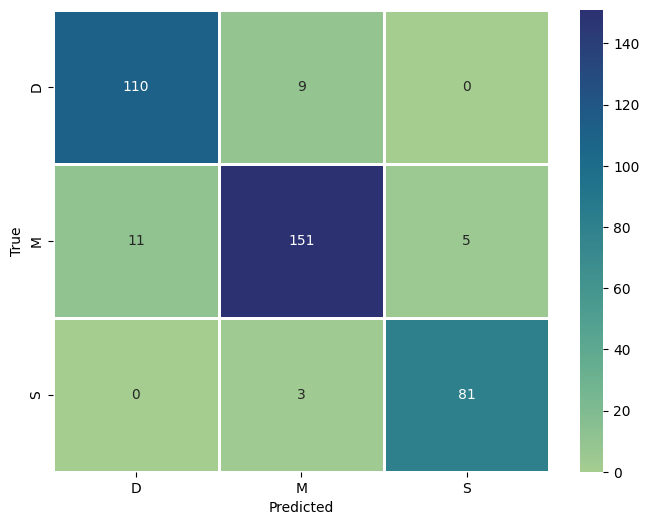

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

results = []
evaluate_model("RF", best_random_forest_model, results)
sklearn_eval = print_results(results)
rf_confusion_matrix = sklearn_eval["Confusion Matrix"].values[0]
confusion_matrix_df = pd.DataFrame(rf_confusion_matrix, index=["D", "M", "S"], columns=["D", "M", "S"])

fig, ax = plt.subplots(figsize=(8,6)) 
sns.heatmap(confusion_matrix_df, linewidths=1, annot=True, ax=ax, fmt='g', cmap="crest")
plt.ylabel('True')
plt.xlabel('Predicted')

### Đánh giá giá trị threshold khi dự đoán của model

In [70]:
best_model = best_random_forest_model

In [71]:
def get_labels(y_pred, y_pred_proba, threshold):
    label_result = []
    for index, predicted_class in enumerate(y_pred):
        prediction_probabilities = y_pred_proba[index]
        max_prob = prediction_probabilities.max()

        # Nếu max_prob < threshold thì dự đoán là dự đoán này chưa chắc chắn. 
        label_result.append(predicted_class if max_prob >= threshold else -1)
    return label_result


def calculate_f1_score_by_threshold(test_x, test_y):
    """
    Sẽ thực hiện việc tính toán F1 score cho từng class
    và F1 score trung bình dựa vào các ngưỡng threshold khác nhau
    """
    y_pred = best_model.predict(test_x)
    y_pred_proba = best_model.predict_proba(test_x)

    thresholds = list(np.arange(0, 1.05, 0.01))
    f1_score_results = []

    optimal_threshold = 0
    max_proba_all_classes = 0
    for threshold in thresholds:
        predictions = get_labels(y_pred, y_pred_proba, threshold)

        # Lưu f1 score của từng class và f1 score trung bình của tất cả các class
        f1_s = list(f1_score(test_y, predictions, labels=[0,1,2], average=None))

        # Tính trung bình theo weight các F1 score của các class
        f1_all_class = f1_score(test_y, predictions, labels=[0,1,2], average="weighted")
        if f1_all_class > max_proba_all_classes:
            max_proba_all_classes = f1_all_class
            optimal_threshold = threshold
        
        f1_s.append(f1_all_class)
        f1_score_results.append(f1_s)
    
    print("Optimal threshold for all classes: ", optimal_threshold)
    return thresholds, f1_score_results

Optimal threshold for all classes:  0.0


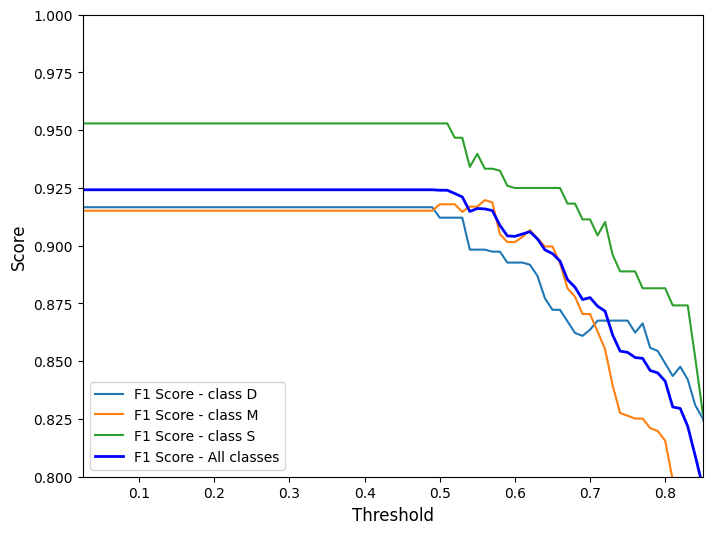

In [72]:
thresholds, f1_scores = calculate_f1_score_by_threshold(X_validation, y_validation)

first_class = [ el[0] for el in f1_scores ]
second_class = [ el[1] for el in f1_scores ]
third_class = [ el[2] for el in f1_scores ]
all_classes = [ el[3] for el in f1_scores ]

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(thresholds, first_class, label = "F1 Score - class D")
plt.plot(thresholds, second_class, label = "F1 Score - class M")
plt.plot(thresholds, third_class, label = "F1 Score - class S")
plt.plot(thresholds, all_classes, label = "F1 Score - All classes", linewidth=2.0, color="blue")
plt.legend(loc = 'lower left')
plt.ylim([0.8, 1])
plt.xlim([0.025, 0.85])
plt.xlabel("Threshold", fontsize = 12)
plt.ylabel("Score", fontsize = 12)
plt.show()

Vậy để độ chính xác khi dự đoán một lớp là cao nhất, ta sẽ chọn `threshold là 0.5` (rơi vào vị trí độ chính xác trung bình khi dự đoán 1 class là cao nhất)